# Shallow fully connected networks on CIFAR10 using Keras

This notebook will guide you through the use of the `keras` package to train a shallow network for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998

We will use Tensorflow 2 (TF 2) and the Keras API. If you need to install some packages, use `pip install ...`, e.g. `pip install sklearn` for SciKit Learn.

## Loading the packages

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense
from keras.src.layers import BatchNormalization
import keras
import ssl

In [2]:
tf_version = tf.__version__
print(f"Tensorflow version: {tf_version}")

Tensorflow version: 2.16.1


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


## Loading the raw data
Keras provides easy access to different datasets including MNIST. First load the `mnist` dataset and normalize it to be in the range [0, 1]

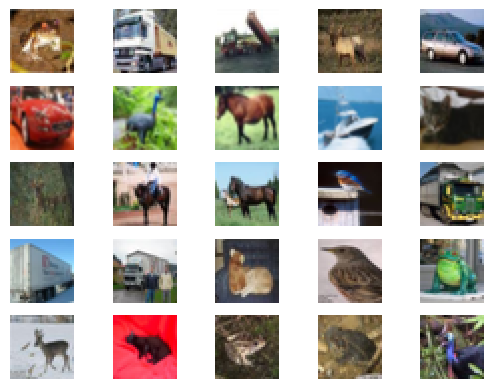

In [4]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0, 5):
        for j in range(0, 5):
            plt.subplot2grid((5, 5), (i, j))
            plt.imshow(X[k], cmap='gray')
            k = k + 1
            plt.axis('off')
    plt.show()


ssl._create_default_https_context = ssl._create_unverified_context
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

show_imgs(X_train)

In [5]:
print(f"Shape of X_train is: {X_train.shape} and X_test is: {X_test.shape}")
print(f"Shape of y_train is: {y_train.shape} and y_test is: {y_test.shape}")
print(f"Number of target values: {len(np.unique(y_train))}")

Shape of X_train is: (50000, 32, 32, 3) and X_test is: (10000, 32, 32, 3)
Shape of y_train is: (50000, 1) and y_test is: (10000, 1)
Number of target values: 10


In [6]:
# print(f"First 5 input values {X_train[:1,:,:]}")
print(f"First 5 target values {y_train[:1, ]}")

First 5 target values [[6]]


In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

(50000, 32, 32, 3) train samples
(10000, 32, 32, 3) test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [8]:
n_classes = 10
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# One-layer network and weight visualisation
## Define the network

In [9]:
model = keras.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=32, strides=1, padding='same', kernel_size=4),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        81,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,498 (326.16 KB)

 Trainable params: 83,498 (326.16 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [30]:
from keras import Sequential
from sklearn.metrics import ConfusionMatrixDisplay


class Result:
    def __init__(self, network, epoch: int, batch_size: int, train_accuracy: [float], val_accuracy: [float],
                 train_loss: [float], val_loss: [float], cm: any):
        self.network = network,
        self.epoch = epoch,
        self.batch_size = batch_size
        self.train_loss = train_loss
        self.val_loss = val_loss
        self.train_accuracy = train_accuracy
        self.val_accuracy = val_accuracy
        self.cm = cm

    def __str__(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch size: {self.batch_size}, Final accuracy: [train:{self.train_accuracy[-1]}, val:{self.val_accuracy[-1]}] Final loss: [train:{self.train_loss[-1]}, val:{self.val_loss[-1]}'

    def title(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch: {self.batch_size}'

    def plot(self, plot_cm):
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(self.train_loss, label='Training loss')
        ax1.plot(self.val_loss, label='Testing loss')
        ax1.legend()
        ax1.grid()
        ax2.plot(self.train_accuracy, label='Training acc')
        ax2.plot(self.val_accuracy, label='Testing acc')
        ax2.legend()
        ax2.grid()
        if plot_cm:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(colorbar=False, cmap='Blues')
        plt.show()

    def plot_result(self, cm=False):
        print("--------------------------------------------")
        print(self.title())
        print(f"Final val accuracy: {self.val_accuracy[-1]}")
        self.plot(cm)

    def print_results(self):
        print("--------------------------------------------")
        print(self.title())
        print(f"Validation accuracy: {self.val_accuracy[-1]}")
        print(f"Train accuracy: {self.train_accuracy[-1]}")


results: [Result] = []

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6829 - loss: 0.9126 - val_accuracy: 0.6375 - val_loss: 1.0517
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7004 - loss: 0.8705 - val_accuracy: 0.6434 - val_loss: 1.0339
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7070 - loss: 0.8551 - val_accuracy: 0.6421 - val_loss: 1.0284
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7142 - loss: 0.8395 - val_accuracy: 0.6268 - val_loss: 1.0683
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7208 - loss: 0.8225 - val_accuracy: 0.6465 - val_loss: 1.0341
--------------------------------------------
Network: (True,), Epochs: (5,), Batch: 128
Validation accuracy: 0.6464999914169312
Train accuracy: 0.7202000021934509


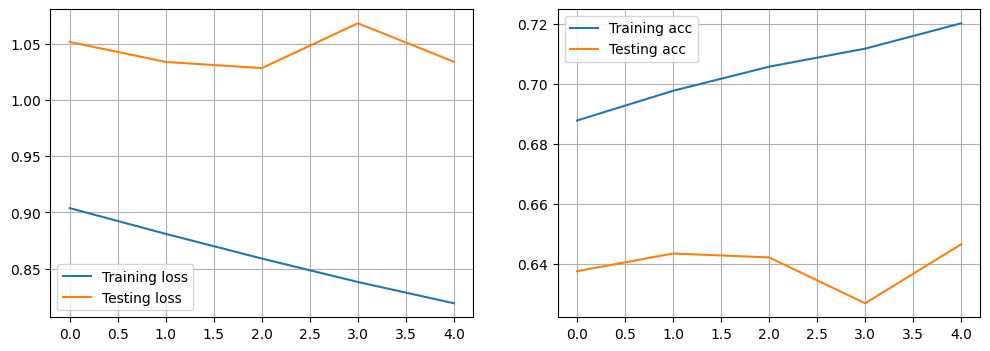

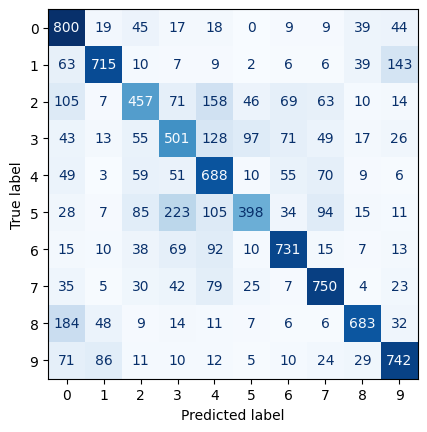

In [29]:
n_epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), verbose=0)

pred = model.predict(X_test, verbose=0)
y_pred = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred)
results.append(
    Result("[Con2D 32_filters 3_kernel 1_stride 0_padding, ReLu, MaxPool 2_size, Flatten, Softmax]", n_epochs,
           batch_size, log.history['accuracy'], log.history['val_accuracy'], log.history['loss'],
           log.history['val_loss'], cm))
results[-1].print_results()

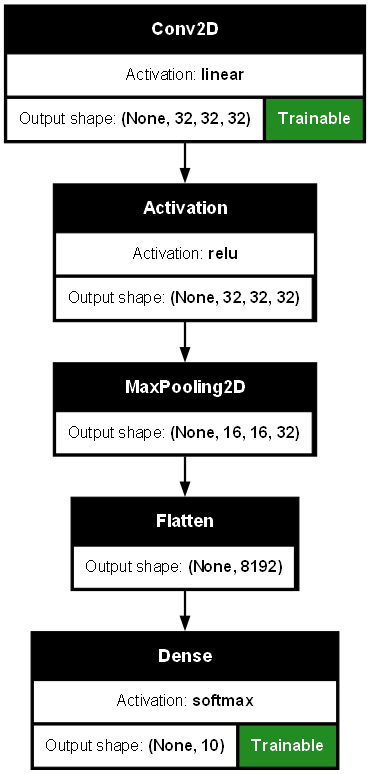

In [12]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=80,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

In [ ]:
weights = model.get_layer(index=0).get_weights()[0]

num_filters = weights.shape[3]
num_cols = 8
num_rows = np.ceil(num_filters / num_cols).astype(int)

plt.figure(figsize=(10, 10))
for i in range(num_filters):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(weights[:, :, 0, i])  # Assuming grayscale filters
    plt.axis('off')
    plt.title(f'Filter {i + 1}')

plt.tight_layout()
plt.show()

# More complex Model
128 neurons, one hidden layer, 30 training epochs, batch size of 128 images, relu activation on the hidden layer, a softmax activation at the output layer, categorical-crossentropy loss and adam optimizer

### Train different models

In [ ]:
model = keras.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=64, strides=1, padding=2, kernel_size=5),
    Activation(activation='relu'),
    Conv2D(filters=32, strides=1, padding=2, kernel_size=4),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(n_classes, activation='softmax'),
])

n_epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), verbose=0)

pred = model.predict(X_test, verbose=0)
y_pred = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred)
results.append(
    Result(
        "[Con2D 64_filters 5_kernel 1_stride 2_padding, ReLu, Con2D 32_filters 4_kernel 1_stride 2_padding, ReLu, MaxPool 2_size, Flatten, Softmax]",
        n_epochs,
        batch_size, log.history['accuracy'], log.history['val_accuracy'], log.history['loss'],
        log.history['val_loss'], cm))
results[-1].plot_result()

In [32]:
model = keras.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=64, strides=1, padding=2, kernel_size=6),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=32, strides=1, padding=2, kernel_size=4),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=32, strides=1, padding=2, kernel_size=4),
    Activation(activation='relu'),
    Flatten(),
    Dense(n_classes, activation='softmax'),
])

n_epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), verbose=0)

pred = model.predict(X_test, verbose=0)
y_pred = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred)
results.append(
    Result(
        "[Con2D 64_filters 6_kernel 1_stride 2_padding, ReLu, Con2D 32_filters 4_kernel 1_stride 2_padding, ReLu, MaxPool 2_size, Con2D 32_filters 4_kernel 1_stride 2_padding, MaxPool 2_size, Flatten, Softmax]",
        n_epochs,
        batch_size, log.history['accuracy'], log.history['val_accuracy'], log.history['loss'],
        log.history['val_loss'], cm))
results[-1].plot_result()

NameError: name 'Input' is not defined

In [ ]:
model = keras.Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=64, strides=1, padding=2, kernel_size=6),
    BatchNormalization(),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=32, strides=1, padding=2, kernel_size=4),
    BatchNormalization(),
    Activation(activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(filters=32, strides=1, padding=2, kernel_size=4),
    BatchNormalization(),
    Activation(activation='relu'),
    Flatten(),
    Dense(n_classes, activation='softmax'),
])

n_epochs = 5
batch_size = 128

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test), verbose=0)

pred = model.predict(X_test, verbose=0)
y_pred = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred)
results.append(
    Result(
        "[Con2D 64_filters 6_kernel 1_stride 2_padding, ReLu, Con2D 32_filters 4_kernel 1_stride 2_padding, ReLu, MaxPool 2_size, Con2D 32_filters 4_kernel 1_stride 2_padding, MaxPool 2_size, Flatten, Softmax]",
        n_epochs,
        batch_size, log.history['accuracy'], log.history['val_accuracy'], log.history['loss'],
        log.history['val_loss'], cm))
results[-1].plot_result()

### Show the results and compare

In [ ]:
[result.print_results() for result in results]

With a higher complexity it was possible to achieve a higher validation-accuracy of 0.5.